In [6]:
graphs[0]

Graph(n_nodes=4541, n_node_features=3, n_edge_features=None, n_labels=1)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


config['label_name'] mass
-----------start minmax_scaler-------------
-----------scaler elapsed time (sec):  7.667
rmse:  0.16
mape:  0.69
r:  0.9849844209806764


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


config['label_name'] rim
-----------start minmax_scaler-------------
-----------scaler elapsed time (sec):  7.737
rmse:  350.29
mape:  2.25
r:  0.9781692319501593
config['label_name'] disk
-----------start minmax_scaler-------------
-----------scaler elapsed time (sec):  6.508
rmse:  869.85
mape:  5.58
r:  0.9511008806061174
Plot saved at: /workspace/scatter-hist.png


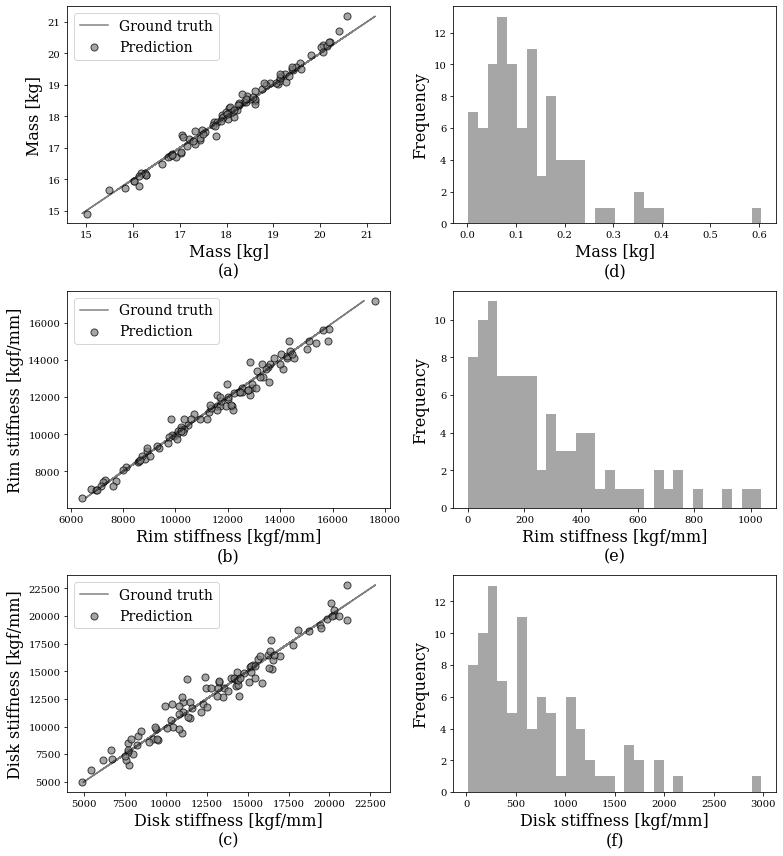

In [4]:

import sys
import os

# Add the directory where your scripts are located
sys.path.append('/workspace')
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# Load custom functions from utils.py
from utils import metrics_rmse, metrics_mape
from config import load_config_2
from spektral.data import Graph
from spektral.layers import GCSConv, GlobalAvgPool
import pickle
import matplotlib.font_manager as fm

# Define function to prepare dataset
def load_dataset_for_model(config, graphs):
    # Perform scaling
    print("config['label_name']", config['label_name'])
    scaled_dataset, X_scaler, Y_scaler = minmax_scaler(config, graphs)

    # Store scalers in the config for future use
    config['X_scaler'] = X_scaler
    config['Y_scaler'] = Y_scaler

    # Split dataset
    dataset = split_dataset(scaled_dataset, config['num_tr'], config['num_val'])

    return dataset, X_scaler, Y_scaler


# Set global font to Times New Roman
def set_times_new_roman_font():
    try:
        plt.rcParams['font.family'] = 'Times New Roman'
        if 'Times New Roman' not in [f.name for f in fm.fontManager.ttflist]:
            raise ValueError("Times New Roman not found")
    except ValueError:
        # Fallback to serif if Times New Roman is not available
        plt.rcParams['font.family'] = 'serif'

set_times_new_roman_font()  # Apply the font globally

def get_config(label_name):
    if label_name == "disk":
        return load_config_2(
            mode="train", best_iteration=1, best_model_loss=0.00136, best_model_r=0.96874,
            best_model_num_subdivide=4, best_model_num_cluster=3834, mesh_ratio=0.005,
            model_name="gcs3", trans_name="GCSConv", trans=GCSConv, label_num=1,
            label_name="disk", epochs=10000, patience=50, num_subdivide=4, num_cluster=3834,
            learning_rate=0.0002, transfer_learning=False, transfer_best_or_prev=False,
            mode_two="BO", iteration=1
        )
    elif label_name == "rim":
        return load_config_2(
            mode="train", best_iteration=34, best_model_loss=0.0003, best_model_r=0.993,
            best_model_num_subdivide=3, best_model_num_cluster=4626, mesh_ratio=0.005,
            model_name="gcs3", trans_name="GCSConv", trans=GCSConv, label_num=1,
            label_name="rim", epochs=10000, patience=50, num_subdivide=3, num_cluster=4626,
            learning_rate=0.0002, transfer_learning=False, transfer_best_or_prev=False,
            mode_two="BO", iteration=34
        )
    elif label_name == "mass":
        return load_config_2(
            mode="train", best_iteration=11, best_model_loss=0.00053, best_model_r=0.984,
            best_model_num_subdivide=3, best_model_num_cluster=4557, mesh_ratio=0.005,
            model_name="gcs3", trans_name="GCSConv", trans=GCSConv, label_num=1,
            label_name="mass", epochs=10000, patience=50, num_subdivide=3, num_cluster=4557,
            learning_rate=0.0002, transfer_learning=False, transfer_best_or_prev=False,
            mode_two="BO", iteration=11
        )

def load_graphs_for_config(config):
    return check_previous_graph(config)

def check_previous_graph(config):
    config["make_subdivided_graph_bool"] = True

    if config["make_subdivided_graph_bool"]:
        names = [file[:-4] for file in os.listdir(config["graphs_dir"]) if file[-4:] == '.pkl']
        for name in names:
            if name == f'subdivided_{config["num_subdivide"]}_{config["num_cluster"]}':
                with open(f'{config["graphs_dir"]}/{name}.pkl', 'rb') as f:
                    load_graphs = pickle.load(f)
                    config["make_subdivided_graph_bool"] = False

    if config["make_subdivided_graph_bool"]:
        with open(f'{config["graphs_dir"]}/graphs.pkl', 'rb') as f:
            load_graphs = pickle.load(f)

    return load_graphs

# Define the model paths in the new order (mass, rim, disk)
model_paths = [
    "/workspace/data/11_gcs3_mass_3_4557_0.00053_0.984.h5",  # mass
    "/workspace/data/34_gcs3_rim_3_4626_0.0003_0.993.h5",    # rim
    "/workspace/data/1_gcs3_disk_4_3834_0.00136_0.96874.h5"   # disk
]

# Define label names for each model in the same order (mass, rim, disk)
label_names = [
    "mass",
    "rim",
    "disk"
]

# Load the models
models = [load_model(path, custom_objects={"GCSConv": GCSConv, "GlobalAvgPool": GlobalAvgPool}) for path in model_paths]

from tensorflow.keras.losses import mse

loss_fn = mse

def test_step(config, dataset, pre_model):
    target_set = []
    pred_set = []

    # Iterate through the list of graphs in the dataset
    for graph in dataset:
        target = graph.y

        # Convert SparseTensor to dense if necessary
        if isinstance(graph.a, tf.SparseTensor):
            adj_dense = tf.sparse.to_dense(graph.a)
        else:
            adj_dense = graph.a

        # Make predictions using the dense adjacency matrix
        pred = pre_model([graph.x[np.newaxis, :, :], adj_dense[np.newaxis, :, :]], training=False)

        # Store targets and predictions
        target_set.append(target)
        pred_set.append(pred[:, 0])

    Y_scaler = config['Y_scaler']
    y_true = Y_scaler.inverse_transform(target_set)
    y_pred = Y_scaler.inverse_transform(pred_set)

    rmse = metrics_rmse(y_true, y_pred)
    mape = metrics_mape(y_true, y_pred)
    r = r2_score(y_true, y_pred)

    print("rmse: ", rmse)
    print("mape: ", mape)
    print("r: ", r)

    return y_true, y_pred, rmse, mape, r

label_fontsize = 16  # Font size for x and y labels
legend_fontsize = 14  # Font size for legend

# Function to plot R² and Absolute Error Histogram in subplots
def plot_combined(y_true, y_pred, ae_values, label_name, index):
    label_map = {
        'mass': 'Mass [kg]',
        'rim': 'Rim stiffness [kgf/mm]',
        'disk': 'Disk stiffness [kgf/mm]'
    }
    x_label = label_map.get(label_name, label_name)

    # Add subplot title (a), (b), (c), etc.
    subplot_title_map = {
        1: "\n(a)", 2: "\n(d)", 3: "\n(b)", 4: "\n(e)", 5: "\n(c)", 6: "\n(f)"
    }

    # Scatter plot with R²
    plt.subplot(3, 2, index * 2 - 1)
    plt.plot(y_true, y_true, alpha=0.5, label='Ground truth', color='black')
    plt.scatter(y_pred, y_true, s=50, alpha=0.7, edgecolor='black', color='gray', label=f'Prediction')
    plt.xlabel(x_label + subplot_title_map[index * 2 - 1], fontsize=label_fontsize)
    plt.ylabel(x_label, fontsize=label_fontsize)
    plt.legend(loc='upper left', fontsize=legend_fontsize)

    # Histogram of absolute errors
    plt.subplot(3, 2, index * 2)
    plt.hist(np.array(ae_values).flatten(), bins=30, color='gray', alpha=0.7)
    plt.xlabel(x_label + subplot_title_map[index * 2], fontsize=label_fontsize)
    plt.ylabel('Frequency', fontsize=label_fontsize)

# Function to plot all models in a single figure
def plot_all_models(r2_scores, ae_values_list, y_true_list, y_pred_list, label_names, save_path=None):
    plt.figure(figsize=(11, 12))

    for i, (r2, ae_values, y_true, y_pred, label_name) in enumerate(zip(r2_scores, ae_values_list, y_true_list, y_pred_list, label_names)):
        plot_combined(y_true, y_pred, ae_values, label_name, i+1)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved at: {save_path}")
        
    plt.show()


# Initialize empty lists to store R² scores and Absolute Error values
r2_scores = []
ae_means = []

# Initialize lists to store results for plotting
ae_values_list = []
y_true_list = []
y_pred_list = []

# Loop through each model and evaluate it
for model, label_name in zip(models, label_names):
    # Load config for the current model
    config = get_config(label_name)
    config['num_tr'] = 740
    config['num_val'] = 92

    # Load the graphs (replace with your actual graph loading function)
    graphs = load_graphs_for_config(config)

    # Prepare the dataset
    dataset, X_scaler, Y_scaler = load_dataset_for_model(config, graphs)

    # Evaluate the model and pass the config to the function
    y_true, y_pred, rmse, mape, r = test_step(config, dataset["dataset_te"], model)

    # Calculate absolute errors
    ae_values = np.abs(y_true - y_pred)
    ae_mean = np.mean(ae_values)

    # Store the results
    r2_scores.append(r)
    ae_means.append(ae_mean)
    ae_values_list.append(ae_values)
    y_true_list.append(y_true)
    y_pred_list.append(y_pred)

# Plot the combined results
save_path = '/workspace/scatter-hist.png'
plot_all_models(r2_scores, ae_values_list, y_true_list, y_pred_list, label_names, save_path=save_path)
